<a href="https://colab.research.google.com/github/micah-shull/superstore/blob/main/001_superstore_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### **Why Removing Outliers is Reasonable for Exploration**

When analyzing data, outliers can significantly influence the results, making it difficult to understand the central tendencies and patterns in the majority of the data. For this reason, removing outliers before exploring the data is a practical approach. Below is the rationale for this decision:

#### **1. Outliers Skew Summary Statistics**
- Metrics like the mean, standard deviation, and correlation are highly sensitive to outliers. This can result in summary statistics that do not accurately represent the majority of the data.
- By removing outliers, we can ensure that these metrics are more reflective of typical transactions, providing a clearer picture of the underlying trends.

#### **2. Focus on the Bulk of the Data**
- Most actionable insights come from understanding patterns in the central majority of the data.
- Removing outliers allows us to analyze the "typical" data without the disproportionate influence of extreme values.

#### **3. Outlier-Specific Analysis**
- Outliers are not ignored or discarded—they can be analyzed separately to uncover unique phenomena, such as:
  - High-value sales that could represent significant business opportunities.
  - Operational inefficiencies that need to be addressed.
  - Potential data entry errors or anomalies worth investigating.

---

### **How This Fits Into the Analysis Workflow**
1. **Initial Exploration**:
   - Start by examining the data with outliers to understand the full distribution.
   - Use this step to identify the presence and scale of outliers.

2. **Remove Outliers for Central Trends**:
   - Temporarily remove outliers to calculate summary statistics and explore typical patterns in the data.

3. **Revisit Outliers Separately**:
   - Perform a focused analysis of the outliers to identify their causes and potential business implications.

---

### **Transparency in Methodology**
- The process of detecting and removing outliers is based on statistical methods (e.g., Tukey’s Fences or Modified Z-Score) and is fully documented.
- The thresholds for defining outliers are clearly stated to ensure transparency and reproducibility.

By following this approach, we balance the need for accurate analysis of the central data with the opportunity to extract insights from the outliers. This dual perspective ensures that our conclusions are both representative of typical patterns and attentive to extreme cases.


### Load & Process Data

Dataset loaded successfully.


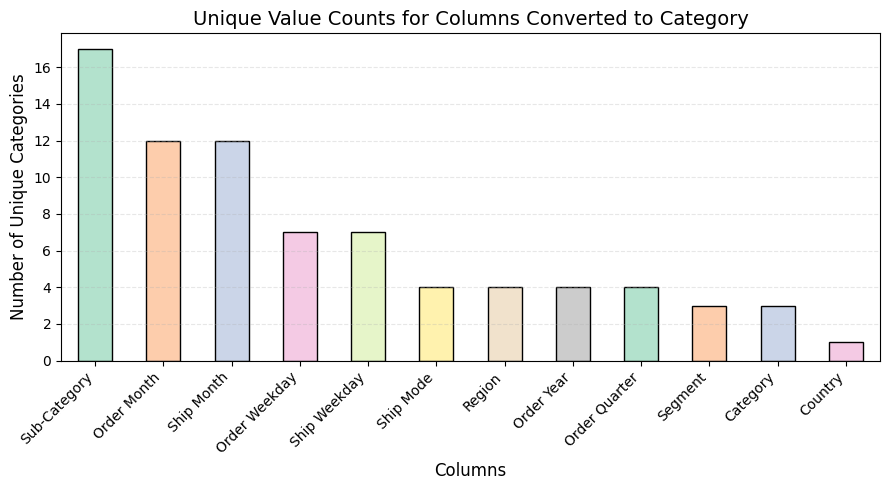

Removed 4985 duplicate rows.
Final dataset structure:
<class 'pandas.core.frame.DataFrame'>
Index: 5009 entries, 0 to 9993
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Row ID                     5009 non-null   int64         
 1   Order ID                   5009 non-null   object        
 2   Order Date                 5009 non-null   datetime64[ns]
 3   Ship Date                  5009 non-null   datetime64[ns]
 4   Ship Mode                  5009 non-null   category      
 5   Customer ID                5009 non-null   object        
 6   Customer Name              5009 non-null   object        
 7   Segment                    5009 non-null   category      
 8   Country                    5009 non-null   category      
 9   City                       5009 non-null   object        
 10  State                      5009 non-null   object        
 11  Postal Code         

In [ ]:
# Import the script
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import data_prep_utils as dpu

# Step 1: Load your dataset
try:
    data = pd.read_excel('sample-superstore.xls')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()

# Step 2: Preprocess the data (derives metrics and standardizes categorical columns)
data = dpu.preprocess_data(data)

# Step 3: Add time-based columns
data = dpu.add_time_based_columns(data)

# Step 4: Convert appropriate columns to category and visualize
exclude_columns = ['Profit per Sub-Category', 'Quantity', 'Estimated Cost', 'Average Discount',
                   'Discount', 'Total Quantity', 'Profit Margin', 'Regional Market Share (%)', 'Profit per Category', 'Order Count']

data = dpu.convert_to_category_and_visualize(data, threshold=25, exclude_columns=exclude_columns)

# Step 5: Remove duplicates
data = dpu.remove_duplicates(data, subset=['Order ID', 'Customer ID'])

# Step 6: (Optional) Standardize specific columns if needed
columns_to_standardize = ['Region', 'Category', 'Sub-Category']
data = dpu.standardize_categorical_columns(data, columns_to_standardize)

# Final check
print("Final dataset structure:")
print(data.info())


### Sales Distributions

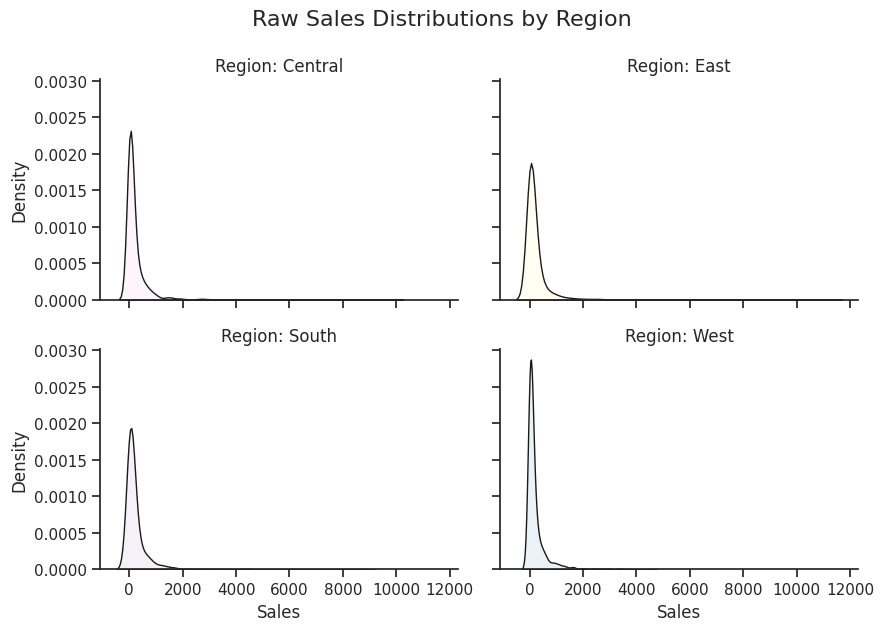

In [ ]:
# Set Seaborn style and context
sns.set_theme(style="ticks", context="notebook")  # "talk" is great for presentations

# Create a grid of KDE plots for Sales by Region
g = sns.FacetGrid(data, col="Region", col_wrap=2, height=3, aspect=1.5, sharex=True, sharey=True, hue="Region", palette="Pastel1_r")
g.map(sns.kdeplot, "Sales", fill=True, edgecolor='k')

# Add titles and adjust layout
g.set_titles("Region: {col_name}")
g.set_axis_labels("Sales", "Density")
g.tight_layout()
g.fig.suptitle("Raw Sales Distributions by Region", fontsize=16, y=1.05)
plt.show()

### Oultier Detection

In [ ]:
from scipy.stats import norm, skew, median_abs_deviation
import numpy as np

# Compute Q1, Q3, and IQR
Q1 = data['Sales'].quantile(0.25)
Q3 = data['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Filter outliers using Tukey's Fences
iqr_outliers = data[(data['Sales'] < lower_fence) | (data['Sales'] > upper_fence)]
iqr_percentage = len(iqr_outliers) / len(data) * 100
print(f"Tukey's Fences detected {len(iqr_outliers)} outliers ({iqr_percentage:.2f}% of the data)")

# Compute Modified Z-Score
median = data['Sales'].median()
mad = median_abs_deviation(data['Sales'])
data['Modified Z-Score'] = 0.6745 * (data['Sales'] - median) / mad

# Filter outliers using Modified Z-Score
modz_outliers = data[data['Modified Z-Score'].abs() > 3.5]
modz_percentage = len(modz_outliers) / len(data) * 100
print(f"Modified Z-Score detected {len(modz_outliers)} outliers ({modz_percentage:.2f}% of the data)")

# Approximate p-value for Modified Z-Score
modz_p_values = 2 * norm.sf(abs(data['Modified Z-Score']))
data['P-Value (Modified Z-Score)'] = modz_p_values
print(f"\nSample Modified Z-Score p-values:\n{data[['Sales', 'Modified Z-Score', 'P-Value (Modified Z-Score)']].head()}\n")

# Test skewness of the Sales distribution
sales_skewness = skew(data['Sales'])
n = len(data['Sales'])
skew_se = np.sqrt(6 / n)  # Standard error for skewness
skew_z = sales_skewness / skew_se  # Z-test for skewness
skew_p_value = 2 * norm.sf(abs(skew_z))  # Two-tailed test
print(f"Skewness of Sales: {sales_skewness:.2f}")
print(f"Z-Score for Skewness: {skew_z:.2f}")
print(f"Skewness test p-value: {skew_p_value:.4f}")

if skew_p_value < 0.05:
    print("The skewness is statistically significant (p < 0.05).")
else:
    print("The skewness is not statistically significant (p >= 0.05).")


Tukey's Fences detected 610 outliers (12.18% of the data)
Modified Z-Score detected 989 outliers (19.74% of the data)

Sample Modified Z-Score p-values:
       Sales  Modified Z-Score  P-Value (Modified Z-Score)
0   261.9600          3.295814                9.813704e-04
2    14.6200         -0.581448                5.609384e-01
3   957.5775         14.200202                9.134908e-46
5    48.8600         -0.044707                9.643405e-01
12   15.5520         -0.566838                5.708240e-01

Skewness of Sales: 9.10
Z-Score for Skewness: 262.89
Skewness test p-value: 0.0000
The skewness is statistically significant (p < 0.05).




### **Outlier Detection Using Tukey’s Fences**

To better understand the central trends in the dataset, we implemented Tukey’s Fences method to detect and handle outliers in the sales data. Outliers can significantly skew summary statistics like the mean and standard deviation, making it important to identify and address them during analysis.

#### **Steps Taken**:
1. **Compute IQR (Interquartile Range)**:
   - Calculated the 1st quartile (\(Q1\)) and 3rd quartile (\(Q3\)).
   - Determined the IQR using \(IQR = Q3 - Q1\).

2. **Define Fences**:
   - Established the range for non-outliers using:
     {Lower Fence} = Q1 - 1.5 times IQR
     {Upper Fence} = Q3 + 1.5 times IQR


3. **Identify Outliers**:
   - **Non-Outliers**: Rows within the range of the lower and upper fences.
   - **Outliers**: Rows outside this range.

4. **Results**:
   - Detected **610 outliers (12.18%)** using Tukey’s Fences.
   - Retained **non-outlier data (87.82%)** for exploring the central trends.

---

#### **Why Tukey’s Fences?**
- **Conservative Approach**: Tukey’s Fences is more conservative than other methods, retaining more data while still identifying extreme values.
- **Focus on Typical Data**: By removing outliers, we ensure that the analysis reflects the central tendencies of the majority of the data.
- **Separate Outlier Analysis**: Outliers are not discarded—they are analyzed separately to uncover potential business insights, such as high-value sales or operational inefficiencies.

---

#### **Visualization**:
We visualized the sales data using a boxplot to illustrate the outliers and the fences:
- Red dashed line: Lower Fence
- Blue dashed line: Upper Fence
This helps stakeholders understand the impact of outliers on the data distribution.



In [ ]:
# Compute Q1, Q3, and IQR
Q1 = data['Sales'].quantile(0.25)
Q3 = data['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Filter non-outliers and outliers
non_outliers = data[(data['Sales'] >= lower_fence) & (data['Sales'] <= upper_fence)]
outliers = data[(data['Sales'] < lower_fence) | (data['Sales'] > upper_fence)]

# Summary of results
print(f"Original Dataset: {len(data)} rows")
print(f"Non-Outliers: {len(non_outliers)} rows ({len(non_outliers) / len(data) * 100:.2f}%)")
print(f"Outliers: {len(outliers)} rows ({len(outliers) / len(data) * 100:.2f}%)")

Original Dataset: 5009 rows
Non-Outliers: 4399 rows (87.82%)
Outliers: 610 rows (12.18%)


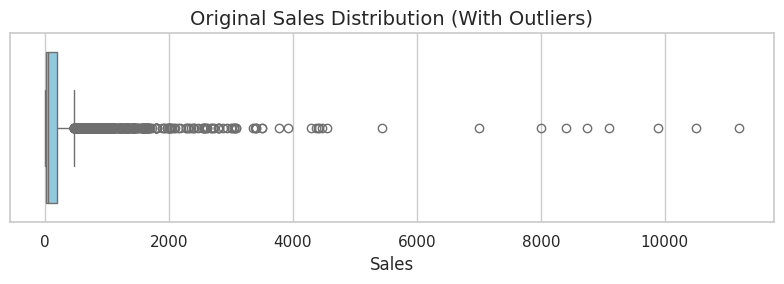

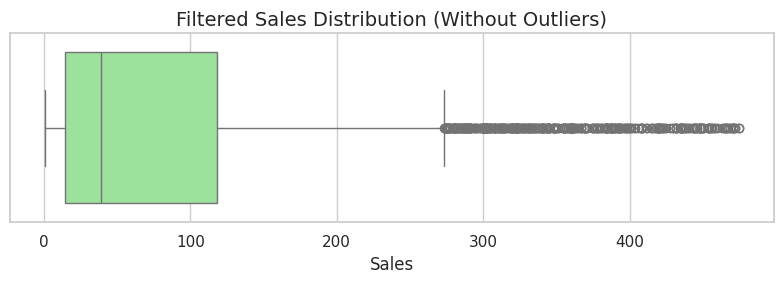

In [ ]:
# Set Seaborn theme
sns.set_theme(style="whitegrid", context="notebook")

# Boxplot for original data
plt.figure(figsize=(8, 3))
sns.boxplot(x=data['Sales'], color='skyblue')
plt.title("Original Sales Distribution (With Outliers)", fontsize=14)
plt.xlabel("Sales", fontsize=12)
plt.tight_layout()
plt.show()

# Boxplot for filtered data
plt.figure(figsize=(8,3))
sns.boxplot(x=non_outliers['Sales'], color='lightgreen')
plt.title("Filtered Sales Distribution (Without Outliers)", fontsize=14)
plt.xlabel("Sales", fontsize=12)
plt.tight_layout()
plt.show()

### Refactor Code for Use in Script

In [ ]:
def remove_outliers_tukey(data, column, plot=True):
    """
    Removes outliers from a specified column in the dataset using Tukey's Fences (IQR Method),
    and optionally plots the data before and after outlier removal.

    Parameters:
    - data (DataFrame): The input dataset.
    - column (str): The column on which to perform outlier detection.
    - plot (bool): Whether to plot boxplots for the original and filtered data.

    Returns:
    - filtered_data (DataFrame): Dataset without outliers.
    - outliers (DataFrame): Outlier data points.

    Example:
        filtered_data, outliers = remove_outliers_tukey(data, column='Sales', plot=True)

    Notes:
        - This function uses Tukey's Fences (IQR method) to detect and remove outliers.
        - Suitable for continuous numeric data with potential outliers.
    """
    # Compute Q1, Q3, and IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Filter data
    filtered_data = data[(data[column] >= lower_fence) & (data[column] <= upper_fence)].copy()
    outliers = data[(data[column] < lower_fence) | (data[column] > upper_fence)].copy()

    # Print summary
    print(f"Column: {column}")
    print(f"Lower Fence: {lower_fence:.2f}, Upper Fence: {upper_fence:.2f}")
    print(f"Original Dataset: {len(data)} rows")
    print(f"Non-Outliers: {len(filtered_data)} rows ({len(filtered_data) / len(data) * 100:.2f}%)")
    print(f"Outliers: {len(outliers)} rows ({len(outliers) / len(data) * 100:.2f}%)")

    # Plotting
    if plot:
        sns.set_theme(style="whitegrid", context="notebook")

        # Plot original data
        if len(data) > 0:
            plt.figure(figsize=(8, 3))
            sns.boxplot(x=data[column], color='skyblue')
            plt.title(f"Original {column} Distribution (With Outliers)", fontsize=14)
            plt.xlabel(column, fontsize=12)
            plt.tight_layout()
            plt.show()

        # Plot filtered data
        if len(filtered_data) > 0:
            plt.figure(figsize=(8, 3))
            sns.boxplot(x=filtered_data[column], color='lightgreen')
            plt.title(f"Filtered {column} Distribution (Without Outliers)", fontsize=14)
            plt.xlabel(column, fontsize=12)
            plt.tight_layout()
            plt.show()

    return filtered_data, outliers



Column: Sales
Lower Fence: -259.31, Upper Fence: 475.57
Original Dataset: 5009 rows
Non-Outliers: 4399 rows (87.82%)
Outliers: 610 rows (12.18%)


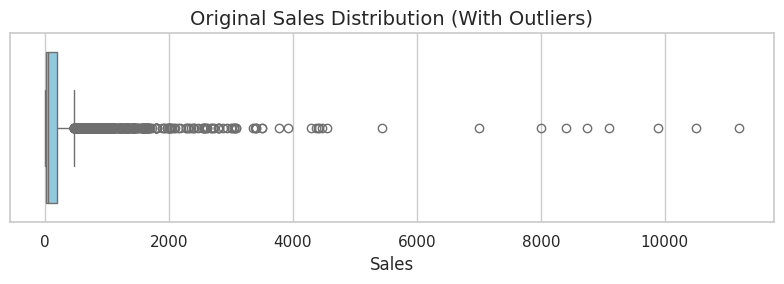

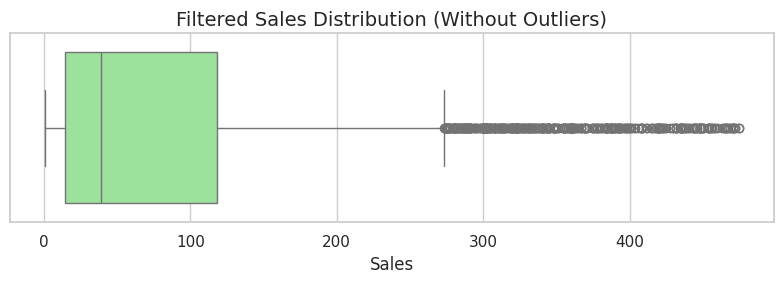

Original Dataset: 5009 rows
Non-Outliers: 4399 rows (87.82%)
Outliers: 610 rows (12.18%)


In [ ]:
non_outliers, outliers = remove_outliers_tukey(data, 'Sales', plot=True)

# Print summary
print(f"Original Dataset: {len(data)} rows")
print(f"Non-Outliers: {len(non_outliers)} rows ({len(non_outliers) / len(data) * 100:.2f}%)")
print(f"Outliers: {len(outliers)} rows ({len(outliers) / len(data) * 100:.2f}%)")


#### Data Utils Script

In [ ]:
script_content=r'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(data):
    """
    Prepares and preprocesses the Superstore dataset by cleaning, deriving core metrics,
    and converting appropriate columns to categorical types.
    """
    # Ensure the order and ship date columns are in datetime format
    data['Order Date'] = pd.to_datetime(data['Order Date'])
    data['Ship Date'] = pd.to_datetime(data['Ship Date'])

    # Derived Metrics
    # 1. Profit Margin
    data['Profit Margin'] = (data['Profit'] / data['Sales']) * 100

    # 2. Estimated Cost
    data['Estimated Cost'] = data['Sales'] - data['Profit']

    # 3. Customer Metrics: Total Sales, Profit, and Order Count
    customer_metrics = data.groupby('Customer ID').agg({
        'Sales': 'sum',
        'Profit': 'sum',
        'Order ID': 'nunique'  # Number of orders
    }).rename(columns={'Order ID': 'Order Count'})

    # 4. Regional Market Share
    region_sales = data.groupby('Region')['Sales'].sum()
    total_sales = data['Sales'].sum()
    regional_market_share = (region_sales / total_sales) * 100

    # Merge customer metrics back to the main dataset
    data = data.merge(customer_metrics, on='Customer ID', suffixes=('', '_Customer'))
    data['Regional Market Share (%)'] = data['Region'].map(regional_market_share)

    # Convert relevant columns to categorical
    categorical_columns = ['Category', 'Sub-Category', 'Region', 'Segment', 'Ship Mode']
    for column in categorical_columns:
        data[column] = data[column].astype('category')

    return data


def convert_to_category_and_visualize(data, threshold=25, exclude_columns=None):
    """
    Converts columns with fewer than 'threshold' unique values to 'category' dtype,
    excluding specified columns, and visualizes the unique value counts.
    """
    if exclude_columns is None:
        exclude_columns = []

    # Count unique values for each column
    unique_counts = data.nunique()

    # Identify columns to convert, excluding specified columns
    columns_to_convert = [
        col for col in unique_counts[unique_counts < threshold].index
        if col not in exclude_columns
    ]

    # Convert selected columns to 'category' dtype
    for column in columns_to_convert:
        data[column] = data[column].astype('category')

    # Filter for columns with fewer than threshold unique values for visualization
    filtered_counts = unique_counts[
        (unique_counts < threshold) & (~unique_counts.index.isin(exclude_columns))
    ]

    # Visualize unique value counts
    palette = sns.color_palette("Pastel2", len(filtered_counts))
    plt.figure(figsize=(9, 5))
    filtered_counts.sort_values(ascending=False).plot(
        kind='bar',
        color=palette,
        edgecolor='black'
    )
    plt.title('Unique Value Counts for Columns Converted to Category', fontsize=14)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Number of Unique Categories', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Verify the conversions
    # print("\nColumns converted to 'category' dtype:")
    # for column in columns_to_convert:
    #     print(f"{column}: {data[column].dtype}")

    return data

def add_time_based_columns(data):
    """
    Adds time-based columns derived from Order Date and Ship Date to the dataset,
    and converts these columns to categorical type for analysis and visualization.
    """
    # Ensure the order and ship date columns are in datetime format
    data['Order Date'] = pd.to_datetime(data['Order Date'])
    data['Ship Date'] = pd.to_datetime(data['Ship Date'])

    # Create new time-based columns
    data['Order Year'] = data['Order Date'].dt.year
    data['Order Quarter'] = data['Order Date'].dt.quarter
    data['Order Month'] = data['Order Date'].dt.month
    data['Order Day'] = data['Order Date'].dt.day
    data['Order Weekday'] = data['Order Date'].dt.day_name()  # e.g., 'Monday', 'Tuesday'

    data['Ship Month'] = data['Ship Date'].dt.month
    data['Ship Day'] = data['Ship Date'].dt.day
    data['Ship Weekday'] = data['Ship Date'].dt.day_name()

    # Convert the new columns to categorical
    time_columns = ['Order Year', 'Order Month', 'Order Month', 'Order Day', 'Order Weekday', 'Ship Month', 'Ship Day', 'Ship Weekday']
    for column in time_columns:
        data[column] = data[column].astype('category')

    return data

def standardize_categorical_columns(data, columns=None):
    """
    Standardizes categorical columns by converting their values to title case.
    If `columns` is None, all categorical columns are standardized.
    """
    if columns is None:
        columns = data.select_dtypes(include='category').columns

    for column in columns:
        if column in data.columns:
            data[column] = data[column].astype(str).str.title().astype('category')
    return data


def remove_duplicates(data, subset=None):
    """
    Removes duplicate rows from the dataset and reports the number of rows removed.

    Parameters:
    - data: DataFrame
        The dataset to remove duplicates from.
    - subset: list or None, optional
        Columns to consider for identifying duplicates. If None, all columns are used.

    Returns:
    - DataFrame: A new DataFrame with duplicates removed.
    """
    initial_shape = data.shape
    # Drop duplicates using the provided subset or across all columns if subset is None
    data = data.loc[~data.duplicated(subset=subset)].copy()
    removed_rows = initial_shape[0] - data.shape[0]
    print(f"Removed {removed_rows} duplicate rows.")
    return data


def calculate_aggregate_metrics(data, group_by_columns):
    """
    Dynamically calculates aggregate metrics for specified groupings.

    Parameters:
    - data: DataFrame
        The dataset to calculate metrics from.
    - group_by_columns: list
        The columns to group the data by.

    Returns:
    - DataFrame: A new DataFrame with the aggregated metrics.
    """
    # Define the aggregation columns and their operations
    aggregation_columns = {
        'Profit': 'sum',
        'Profit Margin': 'mean',
        'Profitability Ratio': 'mean',  # New metric
        'Estimated Cost': 'sum',
        'Sales': 'sum',
        'Discount': 'mean',
        'Order Count': 'sum',
        'Quantity': 'sum',
        'Regional Market Share (%)': 'mean'  # New metric
    }

    # Perform the group-by operation and apply aggregations
    aggregated_data = data.groupby(group_by_columns).agg(**{
        f"Total_{key.replace(' ', '_')}": (key, agg_func)
        for key, agg_func in aggregation_columns.items()
    })

    # Reset index for better readability
    aggregated_data = aggregated_data.reset_index()

    return aggregated_data

def detect_outliers_tukey(data, column):
    """
    Detects outliers using Tukey's Fences method for a specified column.

    Parameters:
    - data: DataFrame
        The dataset to analyze.
    - column: str
        The column for which to detect outliers.

    Returns:
    - non_outliers: DataFrame
        Subset of data without outliers.
    - outliers: DataFrame
        Subset of data containing outliers.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    non_outliers = data[(data[column] >= lower_fence) & (data[column] <= upper_fence)]
    outliers = data[(data[column] < lower_fence) | (data[column] > upper_fence)]

    return non_outliers, outliers

def remove_outliers_tukey(data, column, plot=True):
    """
    Removes outliers from a specified column in the dataset using Tukey's Fences (IQR Method),
    and optionally plots the data before and after outlier removal.

    Parameters:
    - data (DataFrame): The input dataset.
    - column (str): The column on which to perform outlier detection.
    - plot (bool): Whether to plot boxplots for the original and filtered data.

    Returns:
    - filtered_data (DataFrame): Dataset without outliers.
    - outliers (DataFrame): Outlier data points.

    Example:
        filtered_data, outliers = remove_outliers_tukey(data, column='Sales', plot=True)

    Notes:
        - This function uses Tukey's Fences (IQR method) to detect and remove outliers.
        - Suitable for continuous numeric data with potential outliers.
    """
    # Compute Q1, Q3, and IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Filter data
    filtered_data = data[(data[column] >= lower_fence) & (data[column] <= upper_fence)].copy()
    outliers = data[(data[column] < lower_fence) | (data[column] > upper_fence)].copy()

    # Print summary
    print(f"Column: {column}")
    print(f"Lower Fence: {lower_fence:.2f}, Upper Fence: {upper_fence:.2f}")
    print(f"Original Dataset: {len(data)} rows")
    print(f"Non-Outliers: {len(filtered_data)} rows ({len(filtered_data) / len(data) * 100:.2f}%)")
    print(f"Outliers: {len(outliers)} rows ({len(outliers) / len(data) * 100:.2f}%)")

    # Plotting
    if plot:
        sns.set_theme(style="whitegrid", context="notebook")

        # Plot original data
        if len(data) > 0:
            plt.figure(figsize=(8, 3))
            sns.boxplot(x=data[column], color='skyblue')
            plt.title(f"Original {column} Distribution (With Outliers)", fontsize=14)
            plt.xlabel(column, fontsize=12)
            plt.tight_layout()
            plt.show()

        # Plot filtered data
        if len(filtered_data) > 0:
            plt.figure(figsize=(8, 3))
            sns.boxplot(x=filtered_data[column], color='lightgreen')
            plt.title(f"Filtered {column} Distribution (Without Outliers)", fontsize=14)
            plt.xlabel(column, fontsize=12)
            plt.tight_layout()
            plt.show()

    return filtered_data, outliers


'''

with open("data_prep_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_prep_utils.py")

# Import and reload the module to use its functions
import importlib
import data_prep_utils as dpu
importlib.reload(dpu)



Script successfully written to data_prep_utils.py


<module 'data_prep_utils' from '/content/data_prep_utils.py'>

###Test Updated PreProcess Script

Dataset loaded successfully.


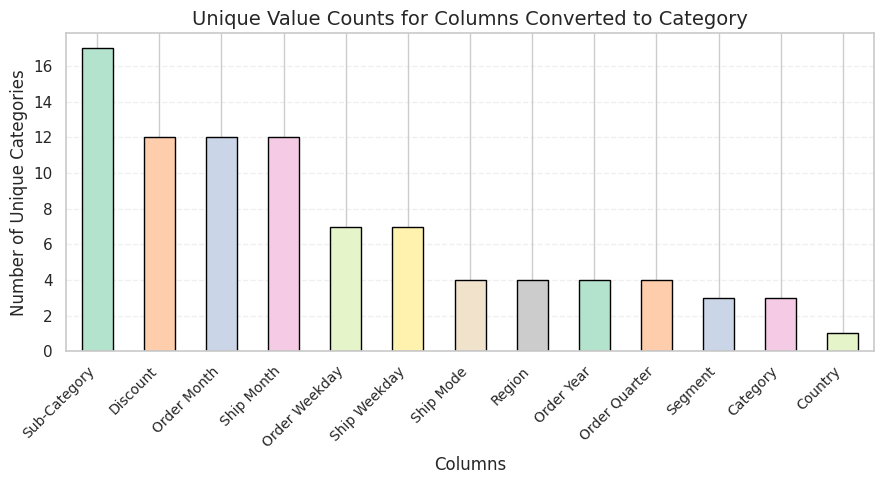

Removed 4985 duplicate rows.
Column: Sales
Lower Fence: -259.31, Upper Fence: 475.57
Original Dataset: 5009 rows
Non-Outliers: 4399 rows (87.82%)
Outliers: 610 rows (12.18%)


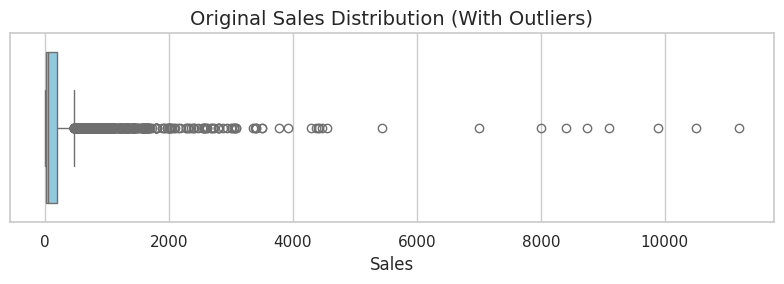

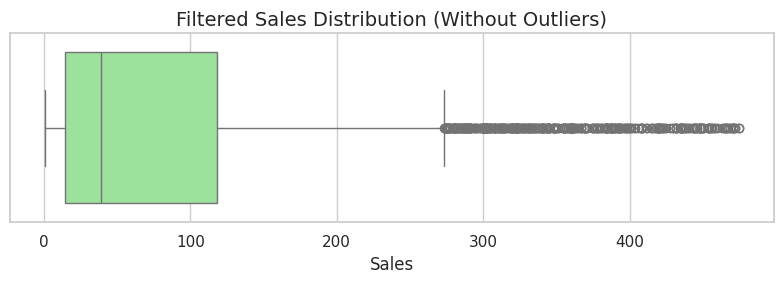

Final dataset structure:
<class 'pandas.core.frame.DataFrame'>
Index: 4399 entries, 0 to 9993
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Row ID                     4399 non-null   int64         
 1   Order ID                   4399 non-null   object        
 2   Order Date                 4399 non-null   datetime64[ns]
 3   Ship Date                  4399 non-null   datetime64[ns]
 4   Ship Mode                  4399 non-null   category      
 5   Customer ID                4399 non-null   object        
 6   Customer Name              4399 non-null   object        
 7   Segment                    4399 non-null   category      
 8   Country                    4399 non-null   category      
 9   City                       4399 non-null   object        
 10  State                      4399 non-null   object        
 11  Postal Code                4399 non-null   int64 

In [ ]:
# Step 1: Load your dataset
try:
    data = pd.read_excel('sample-superstore.xls')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()

# Step 2: Preprocess the data (derives metrics and standardizes categorical columns)
data = dpu.preprocess_data(data)

# Step 3: Add time-based columns
data = dpu.add_time_based_columns(data)

# Step 4: Convert appropriate columns to category and visualize
exclude_columns = ['Profit per Category', 'Profit per Sub-Category', 'Regional Market Share (%)', 'Quantity', 'Order Count']
data = dpu.convert_to_category_and_visualize(data, threshold=25, exclude_columns=exclude_columns)

# Step 5: Remove duplicates
data = dpu.remove_duplicates(data, subset=['Order ID', 'Customer ID'])

# Step 6: (Optional) Standardize specific columns if needed
columns_to_standardize = ['Region', 'Category', 'Sub-Category']
data = dpu.standardize_categorical_columns(data, columns_to_standardize)

# Step 7: Remove outliers in the 'Sales' column using Tukey's Fences
filtered_data, outliers = dpu.remove_outliers_tukey(data, column='Sales', plot=True)

# Final check
print("Final dataset structure:")
print(filtered_data.info())


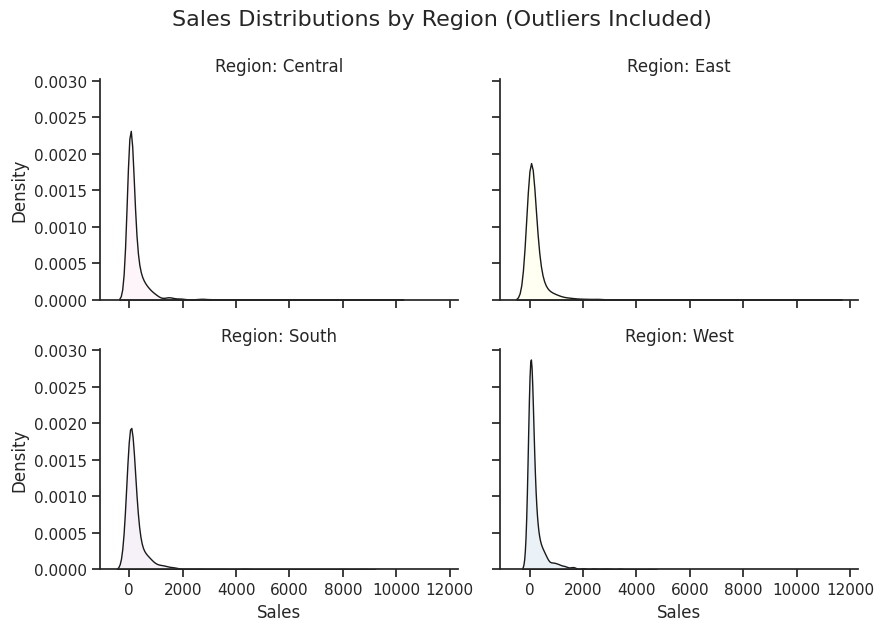

In [ ]:
# Set Seaborn style and context
sns.set_theme(style="ticks", context="notebook")  # "talk" is great for presentations

# Create a grid of KDE plots for Sales by Region
g = sns.FacetGrid(data, col="Region", col_wrap=2, height=3, aspect=1.5, sharex=True, sharey=True, hue="Region", palette="Pastel1_r")
g.map(sns.kdeplot, "Sales", fill=True, edgecolor='k')

# Add titles and adjust layout
g.set_titles("Region: {col_name}")
g.set_axis_labels("Sales", "Density")
g.tight_layout()
g.fig.suptitle("Sales Distributions by Region (Outliers Included)", fontsize=16, y=1.05)
plt.show()

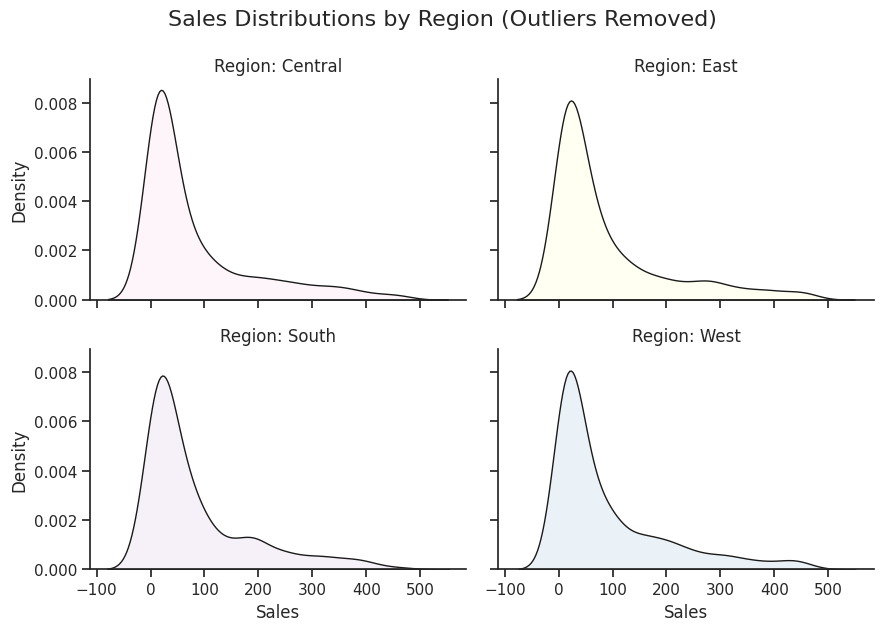

In [ ]:
# Set Seaborn style and context
sns.set_theme(style="ticks", context="notebook")  # "talk" is great for presentations

# Create a grid of KDE plots for Sales by Region
g = sns.FacetGrid(filtered_data, col="Region", col_wrap=2, height=3, aspect=1.5, sharex=True, sharey=True, hue="Region", palette="Pastel1_r")
g.map(sns.kdeplot, "Sales", fill=True, edgecolor='k')

# Add titles and adjust layout
g.set_titles("Region: {col_name}")
g.set_axis_labels("Sales", "Density")
g.tight_layout()
g.fig.suptitle("Sales Distributions by Region (Outliers Removed)", fontsize=16, y=1.05)
plt.show()